# Elasticsearch setup

In [19]:
from elasticsearch import Elasticsearch

es = Elasticsearch([{'host': 'localhost', 'port': 9200}])

stoplist = open('../HW1/reference/stoplist.txt')
stoplist = [line.strip() for line in stoplist]

In [2]:
es.indices.create(index = 'email_index', ignore=400, body= {
    "settings" : {
        "number_of_shards": 1,
        "number_of_replicas": 1,
        "max_result_window" : 30000,
        "analysis": {
            "filter": {
                "english_stop": {
                    "type": "stop",
                    "stopwords": stoplist
                },
                "my_stemmer": {
                    "type": "stemmer",
                    "name": "english"
                }
            },
            "analyzer": {
                "stopped": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "lowercase",
                        "english_stop",
                        "my_stemmer"
                    ]
                }
            }
        }
    },
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "fielddata": True,
                "analyzer": "stopped",
                "index_options": "positions",
                "term_vector": "yes"
            }
        }
    }
})

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'email_index'}

# Index data to Elasticsearch

In [15]:
from elasticsearch.helpers import bulk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from tqdm import tqdm
import string
import email
import time
import os
import re

DATA_PATH = './trec07p/data/'
LABEL_PATH = './trec07p/full/index'

def get_labels(LABEL_PATH):
    labels = {}
    with open(LABEL_PATH, 'r') as file:
        for line in file:
            splits = re.split(' |/', line.strip())
            label, id = splits[0], splits[-1]
            labels[id] = spam_or_ham(label)
    return labels

def spam_or_ham(label):
    if label == 'spam':
        return 1
    else:
        return 0

def is_not_number(token):
    try:
        float(token)
    except ValueError:
        return True
    return False

def msg_unzipper(msg):
    parts, subject = [], msg['Subject']
    if msg.is_multipart():
        for payload in msg.get_payload():
            if payload.is_multipart():
                for part in payload.get_payload():
                    parts.append(part)
            else:
                parts.append(payload)
    else:
        parts.append(msg)
    return subject, parts

def translate_and_stem(raw_text):
    if raw_text is None:
        return str(raw_text)
    else:
        tokens = word_tokenize(raw_text.translate(translator))
        text = ' '.join([snowball.stem(token) for token in tokens if is_not_number(token)])
        return text

In [16]:
blacklist = ['[document]', 'noscript', 'header', 'html', 'meta', 'head', 'input', 'script']
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
snowball = SnowballStemmer('english')

def yield_data(mail, index_name):
    global labels
    
    with open(os.path.join(DATA_PATH, mail), 'r', encoding='ISO-8859-1') as file:
        content = ''
        msg = email.message_from_file(file)
        subject, parts = msg_unzipper(msg)
        subject = translate_and_stem(subject)
        type_set.add(msg.get_content_type())
        for part in parts:
            raw_text, text = '', ''
            if part.get_content_type() == 'text/html':
                soup = BeautifulSoup(part.get_payload(), 'html.parser')
                test = soup.find_all(text=True)
                raw_text = ' '.join([t for t in test if t.parent.name not in blacklist])
            elif part.get_content_type() == 'text/plain':
                raw_text = part.get_payload()
            else:
                continue
            text = translate_and_stem(raw_text)
            if msg.get_content_type() == 'multipart/alternative':
                content = text
                break
            content = content + '\n\n' + text

        es.index(index=index_name, id=mail, body={
            'spam': labels[mail],
            'subject': str(subject),
            'content-type': str(msg.get_content_type()),
            'content': content           
        })

def bulk_index(DATA_PATH):
    mails = os.listdir(DATA_PATH)
    counter = 0
    for mail in tqdm(mails):
        yield_data(mail, 'email_index')

In [191]:
bulk_index(DATA_PATH)

# 

# HW7 Part 1: Manual unigrams

## Create sparse matrix

In [23]:
def create_maps_4_matrix():
    unigram_map, email_map = {}, {}
    with open('part1/unigrams.txt', 'r', encoding='ISO-8859-1') as file:
        index = 0
        unigrams = file.read().split()
        unigrams = set([translate_and_stem(item) for item in unigrams if translate_and_stem(item) != ''])
        for unigram in unigrams:
            unigram_map[unigram] = index
            index += 1
    index = 0
    for email in labels.keys():
        email_map[email] = index
        index += 1
    return unigrams, unigram_map, email_map

labels = get_labels(LABEL_PATH)
unigrams, unigram_map, email_map = create_maps_4_matrix()

In [25]:
import scipy.sparse as sps
from tqdm import tqdm
sparse_matrix = sps.csr_matrix((len(email_map), len(unigram_map) + 1))

def create_sparse_matrix(unigrams):
    for unigram in tqdm(unigrams):
        print(unigram, end = ' ')
        res = es.search(index='email_index', body={"query":{"multi_match":{"query":unigram, "fields": [ "subject", "content" ] }},"size":30000})
        for hit in res['hits']['hits']:
            id, score, label = hit['_id'], hit['_score'], hit['_source']['spam']
            sparse_matrix[(email_map[id], unigram_map[unigram])] = score
            sparse_matrix[(email_map[id], len(unigram_map))] = int(label)

create_sparse_matrix(unigrams)

## Generate feature matrix according to sparse matrix

In [78]:
import pandas as pd

# feature_matrix = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)
# feature_matrix.to_csv(r'./part1/feature_matrix_feedback.csv')
feature_matrix = pd.read_csv("part1/feature_matrix_feedback.csv")
feature_matrix = feature_matrix.iloc[:,1:]
feature_matrix

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.000000,1.399139,3.454762,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,1.685125,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,3.269573,1.377640,0.000000,0.0,0.000000,0.0,0.000000,5.575565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75414,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.336253,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75415,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.336253,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75416,0.0,0.000000,0.000000,0.963219,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75417,0.0,1.494421,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Manually inspect top spams

In [77]:
score_map = {}
score_matrix = feature_matrix.iloc[:, :-1]
for i in range(len(score_matrix)):
    id = (list(email_map.keys())[list(email_map.values()).index(i)])
    score = sum(score_matrix.loc[i])
    score_map[id] = score

In [135]:
import email
sorted_score_map = {k: v for k, v in sorted(score_map.items(), key=lambda item: item[1], reverse=True)}
with open('part1/top10_spams.txt', 'w') as file:
    for i in range(10):
        id = list(sorted_score_map.keys())[i]
        # score = list(sorted_score_map.values())[i]
        file.write('id: {}\n'.format(id))
        with open('./trec07p/data/' + id, 'r', encoding='ISO-8859-1') as f:
            msg = email.message_from_file(f)
            file.write(str(msg))

In [133]:
labels['inmail.5342']

1

## Classification

In [48]:
X = feature_matrix.values[:,:-1]
y = feature_matrix.values[:,-1].astype(int)
print(X.shape, y.shape)

(75419, 270) (75419,)


In [49]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 
regr = LogisticRegression(solver='newton-cg', fit_intercept=True)
clf = DecisionTreeClassifier()
mnb = MultinomialNB()

regr.fit(X_train, y_train.ravel())
predictions = regr.predict(X_test)
print('Regression Score: {:.6f}%'.format(regr.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

clf = clf.fit(X_train,y_train.ravel())
predictions = clf.predict(X_test)
print('Decision Tree Score: {:.6f}%'.format(clf.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

mnb = mnb.fit(X_train, y_train.ravel())
predictions = mnb.predict(X_test)
print('Naive Bayes Score: {:.6f}%'.format(mnb.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

Regression Score: 70.564837%
ROC AUC score: 68.970951%
Decision Tree Score: 71.884116%
ROC AUC score: 71.974078%
Naive Bayes Score: 64.936356%
ROC AUC score: 60.262905%


# HW7 Part 2: Entire unigrams

## Create sparse matrix

In [20]:
from tqdm import tqdm

def create_sparse_matrix(index):
    features_in_str = []
    for id in tqdm(labels.keys()):
        feature_list = []
        res = es.termvectors(index=index, id=id, fields=['subject', 'content'])['term_vectors']
        try:
            for term in res['content']['terms']:
                feature_list.append(term)
        except:
            pass
        try:
            for term in res['subject']['terms']:
                feature_list.append(term)
        except:
            pass
        features_in_str.append(' '.join(feature_list))
    return features_in_str

features_in_str = create_sparse_matrix('email_index')

100%|██████████| 75419/75419 [04:28<00:00, 280.83it/s]


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sps
import numpy as np

row, col, data = [], [], []
vectorizer = CountVectorizer(min_df=0.02, max_df=0.95)

X = vectorizer.fit_transform(features_in_str)
feature_names = vectorizer.get_feature_names()

for i, label in enumerate(labels.values()):
    row.append(i)
    col.append(0)
    data.append(label)

y = sps.csr_matrix((data, (row, col)), shape=(len(labels), 1))

print(X.shape, y.shape)

(75419, 1133) (75419, 1)


## Generate feature matrix according to sparse matrix

In [11]:
import pandas as pd

feature_matrix_2 = pd.DataFrame.sparse.from_spmatrix(X)
feature_matrix_2['label'] = y.toarray()
feature_matrix_2

,0,1,2,3,4,5,6,7,8,9,...,1124,1125,1126,1127,1128,1129,1130,1131,1132,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75414,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,2,0,0,0,0,1
75415,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,2,0,0,0,0,1
75416,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
75417,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


## dump and load train/test set

In [111]:
from sklearn.datasets import dump_svmlight_file

dump_svmlight_file(X, y, f='part2/features.txt')

In [1]:
from sklearn.datasets import load_svmlight_file

X, y = load_svmlight_file(f='part2/features.txt')

## Classification - Decision Tree, Naive Bayes, Logistic Regression

In [9]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train.ravel())
predictions = clf.predict(X_test)
print('Decision Tree Score: {:.6f}%'.format(clf.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

mnb = MultinomialNB()
mnb = mnb.fit(X_train, y_train.ravel())
predictions = mnb.predict(X_test)
print('Naive Bayes Score: {:.6f}%'.format(mnb.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

regr = LogisticRegression(solver='newton-cg', fit_intercept=True)
regr = regr.fit(X_train, y_train.ravel())
predictions = regr.predict(X_test)
print('Regression Score: {:.6f}%'.format(regr.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

Decision Tree Score: 98.568019%
ROC AUC score: 98.342108%
Naive Bayes Score: 90.294352%
ROC AUC score: 92.310458%
Regression Score: 98.998939%
ROC AUC score: 98.754294%


## Classification - Liblinear Regression

In [10]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

clf = LinearSVC(random_state=0, tol=1e-5)
clf = clf.fit(X_train, y_train.ravel())
predictions = clf.predict(X_test)
print('Decision Tree Score: {:.6f}%'.format(clf.score(X_test, y_test) * 100))
print('ROC AUC score: {:.6f}%'.format(roc_auc_score(y_test, predictions) * 100))

Decision Tree Score: 98.846460%
ROC AUC score: 98.634877%
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

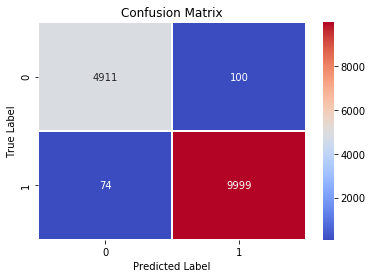

In [12]:
def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=[0, 1],
                yticklabels=[0, 1],
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

show_confusion_matrix(y_test, predictions)

## Feature analysis

In [12]:
def feature_analysis(feature_names, feature_matrix):
    unigram_dict = {}
    filtered_feature_matrix = feature_matrix[feature_matrix['label']==1]
    print(len(filtered_feature_matrix))
    for index, unigram in tqdm(enumerate(feature_names)):
        unigram_dict[unigram] = sum(filtered_feature_matrix[index])
    return unigram_dict
unigram_dict = feature_analysis(feature_names, feature_matrix_2)

0it [00:00, ?it/s]50199
1133it [05:57,  3.17it/s]


In [25]:
import nltk
from nltk.corpus import stopwords

counter = 0
stopwords_set = set(stopwords.words('english'))
unigram_dict = {k: v for k, v in sorted(unigram_dict.items(), key=lambda item: item[1], reverse=True)}
with open('part2/feature_analysis.txt', 'w') as file:
    for unigram, freq in unigram_dict.items():
        if unigram not in stopwords_set:
            if unigram in unigrams:
                file.write('{}: {} - also included in manual unigrams!\n'.format(unigram, freq))
            else:
                file.write('{}: {}\n'.format(unigram, freq))

with open('part2/unigrams_feedback.txt', 'w') as file:
    for unigram in unigrams:
        file.write('{} '.format(unigram))
    for unigram, freq in unigram_dict.items():
        if unigram not in stopwords_set:
            if unigram not in unigrams:
                counter += 1
                file.write('{} '.format(unigram))
        if counter == 200:
            break